In [1]:
import cv2
import numpy as np

def detect_crosswalk_boundaries(image, start_point, end_point):
    # Convert normalized coordinates to pixel coordinates
    height, width = image.shape[:2]
    start_point = (int(start_point[0] * width), int(start_point[1] * height))
    end_point = (int(end_point[0] * width), int(end_point[1] * height))

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define region of interest (ROI)
    roi_top = max(0, min(start_point[1], end_point[1]) - 20)
    roi_bottom = min(height, max(start_point[1], end_point[1]) + 20)
    roi = gray[roi_top:roi_bottom, :]

    # Apply threshold to isolate white stripes
    _, thresh = cv2.threshold(roi, 200, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    # Find leftmost and rightmost points of all contours
    left_x = width
    right_x = 0
    for contour in contours:
        x, _, w, _ = cv2.boundingRect(contour)
        left_x = min(left_x, x)
        right_x = max(right_x, x + w)

    # Adjust for ROI offset
    left_x += 0
    right_x += 0

    # Create boundary points
    top_left = (left_x, start_point[1])
    top_right = (right_x, start_point[1])
    bottom_left = (left_x, end_point[1])
    bottom_right = (right_x, end_point[1])

    return [top_left, top_right, bottom_right, bottom_left]


In [2]:
# Example usage
image = cv2.imread('trial.jpg')
start_point = (0.369629442691803, 0.32424286007881165)  # Example coordinates, replace with your model's output
end_point = (0.45805561542510986, 0.9975407123565674)  # Example coordinates, replace with your model's output

boundaries = detect_crosswalk_boundaries(image, start_point, end_point)

if boundaries:
    # Draw the boundaries on the image
    cv2.polylines(image, [np.array(boundaries)], True, (0, 255, 0), 2)
    
    # Display the result
    cv2.imshow('Crosswalk Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No crosswalk boundaries detected.")

In [3]:
import cv2
import numpy as np

def detect_crosswalk_boundaries(image, start_point, end_point):
    # Convert normalized coordinates to pixel coordinates
    height, width = image.shape[:2]
    start_y = int(start_point[1] * height)
    end_y = int(end_point[1] * height)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    print(gray)
    # Create a horizontal edge detection filter
    filter_width = 51  # Adjust this based on your image size and crosswalk width
    filter_height = 3  # Small vertical height as suggested
    kernel = np.ones((filter_height, filter_width), np.float32) / (filter_width * filter_height)
    kernel[:, :filter_width//2] *= -1  # Make left half negative

    # Apply the filter
    filtered = cv2.filter2D(gray, -1, kernel)
    print(filtered)
    # Find edges in the filtered image
    left_edges = []
    right_edges = []

    for y in range(start_y, end_y, 5):  # Step by 5 pixels for efficiency
        row = filtered[y, :]
        left_edge = np.argmax(row[:width//2])
        right_edge = width//2 + np.argmax(row[width//2:])
        
        if row[left_edge] > 20 and row[right_edge] > 20:  # Threshold to avoid noise
            left_edges.append((left_edge, y))
            right_edges.append((right_edge, y))

    if not left_edges or not right_edges:
        return None

    # Linear regression to find best fit lines
    left_coeffs = np.polyfit([p[1] for p in left_edges], [p[0] for p in left_edges], 1)
    right_coeffs = np.polyfit([p[1] for p in right_edges], [p[0] for p in right_edges], 1)

    # Calculate boundary points
    left_x_start = int(np.polyval(left_coeffs, start_y))
    left_x_end = int(np.polyval(left_coeffs, end_y))
    right_x_start = int(np.polyval(right_coeffs, start_y))
    right_x_end = int(np.polyval(right_coeffs, end_y))

    return [(left_x_start, start_y), (right_x_start, start_y),
            (right_x_end, end_y), (left_x_end, end_y)]

# Example usage
image = cv2.imread('trial.jpg')
start_point = (0.369629442691803, 0.32424286007881165)  # Example coordinates, replace with your model's output
end_point = (0.45805561542510986, 0.9975407123565674)  # Example coordinates, replace with your model's output

boundaries = detect_crosswalk_boundaries(image, start_point, end_point)

if boundaries:
    # Draw the boundaries on the image
    cv2.polylines(image, [np.array(boundaries)], True, (0, 255, 0), 2)
    
    # Display the result
    cv2.imshow('Crosswalk Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No crosswalk boundaries detected.")


[[ 51  47  37 ...   9   9   9]
 [ 36  34  28 ...   8   8   8]
 [ 25  24  20 ...   8   8   8]
 ...
 [216 218 219 ... 209 209 209]
 [216 217 218 ... 209 209 209]
 [217 217 216 ... 209 209 209]]
[[1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]
 [4 4 4 ... 4 4 4]]


In [ ]:
import cv2
import numpy as np

def find_edge(image, start_x, start_y, direction):
    """Find the edge of the crosswalk in the given direction."""
    height, width = image.shape[:2]
    threshold = 200  # Adjust this threshold based on your image characteristics
    
    while 0 <= start_x < width:
        if image[start_y, start_x] > threshold:
            return start_x
        start_x += direction
    return None

def detect_crosswalk_boundaries(image, start_point, end_point):
    # Convert normalized coordinates to pixel coordinates
    height, width = image.shape[:2]
    start_x, start_y = int(start_point[0] * width), int(start_point[1] * height)
    end_x, end_y = int(end_point[0] * width), int(end_point[1] * height)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find edges at different heights
    left_edges = []
    right_edges = []
    step = 5  # Step size for vertical traversal

    for y in range(start_y, end_y, step):
        # Move up a few pixels to ensure we're on a white bar
        for offset in range(0, 20, 2):  # Check up to 20 pixels above in 2-pixel steps
            if gray[y - offset, start_x] > 200:
                y = y - offset
                break
        
        left_edge = find_edge(gray, start_x, y, -1)
        right_edge = find_edge(gray, start_x, y, 1)
        
        if left_edge is not None and right_edge is not None:
            left_edges.append((left_edge, y))
            right_edges.append((right_edge, y))

    if not left_edges or not right_edges:
        return None

    # Linear regression to find best fit lines
    left_coeffs = np.polyfit([p[1] for p in left_edges], [p[0] for p in left_edges], 1)
    right_coeffs = np.polyfit([p[1] for p in right_edges], [p[0] for p in right_edges], 1)

    # Calculate boundary points
    left_x_start = int(np.polyval(left_coeffs, start_y))
    left_x_end = int(np.polyval(left_coeffs, end_y))
    right_x_start = int(np.polyval(right_coeffs, start_y))
    right_x_end = int(np.polyval(right_coeffs, end_y))

    return [(left_x_start, start_y), (right_x_start, start_y),
            (right_x_end, end_y), (left_x_end, end_y)]

# Example usage
image = cv2.imread('trial.jpg')
start_point = (0.369629442691803, 0.32424286007881165)  # Example coordinates, replace with your model's output
end_point = (0.45805561542510986, 0.9975407123565674)  # Example coordinates, replace with your model's output

boundaries = detect_crosswalk_boundaries(image, start_point, end_point)

if boundaries:
    # Draw the boundaries on the image
    cv2.polylines(image, [np.array(boundaries)], True, (0, 255, 0), 2)
    
    # Display the result
    cv2.imshow('Crosswalk Detection', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No crosswalk boundaries detected.")


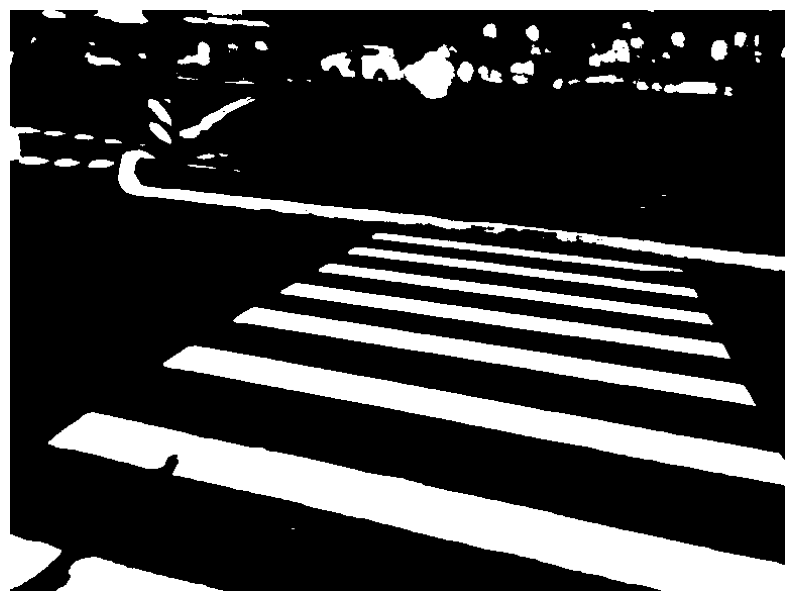

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('trial.png')

# 1. Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 2. Apply thresholding to make pixels either black or white
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# 3. Display the image as output of the cell
plt.figure(figsize=(10, 10))
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()


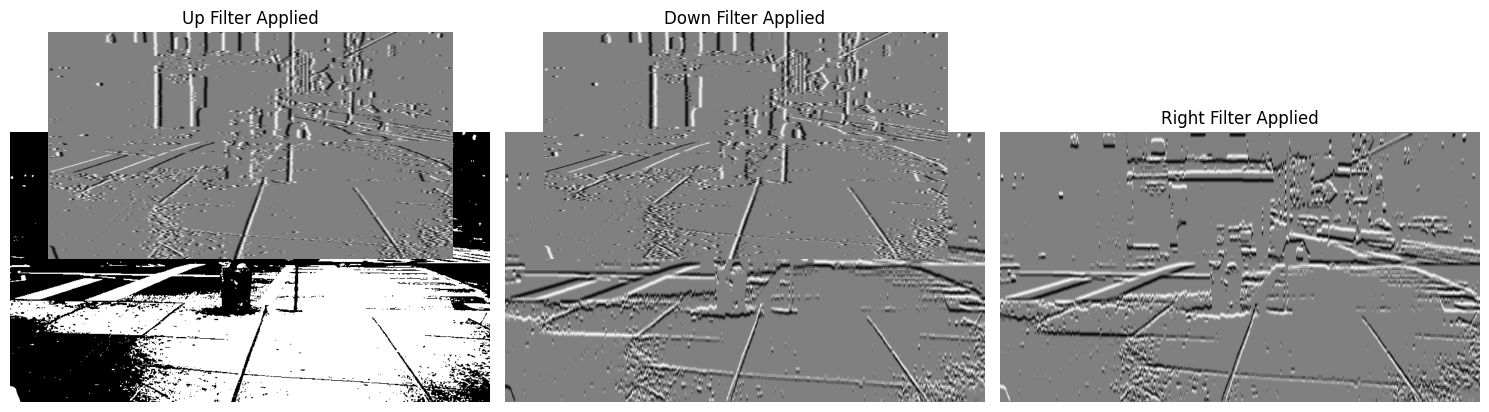

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('image2.jpg')

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to make pixels either black or white
_, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
import cv2

temp = cv2.rotate(binary, cv2.ROTATE_90_CLOCKWISE)


import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def create_corner_kernel(size=(20, 20), black_rows=3, angle=30, edge_thickness=3):
    """
    Creates a corner detection kernel with a tilt and a vertical edge.

    Parameters:
    size: tuple, (height, width) of the kernel.
    black_rows: int, number of top rows to be completely -1.
    angle: float, approximate tilt in degrees.
    edge_thickness: int, number of extra white pixels to the right to capture vertical edges.

    Returns:
    A numpy array representing the corner detection kernel.
    """
    kernel = np.ones(size, dtype=np.float32)  # Start with all ones
    height, width = size
    max_neg_width = width  # Full width has -1 at the top
    min_neg_width = width // 2  # Bottom rows are roughly 50% -1

    for i in range(height):
        if i < black_rows:
            kernel[i, :] = -1  # Fully black for the top rows
        else:
            # Interpolating the transition based on row index (after black rows)
            neg_width = int(min_neg_width + (max_neg_width - min_neg_width) * (1 - (i - black_rows) / (height - black_rows)))
            kernel[i, :neg_width] = -1  # Assign -1 to the left part
            
            # Ensure extra white pixels to the right of the transition for vertical edge detection
            right_edge = min(neg_width + edge_thickness, width)  # Limit to kernel width
            kernel[i, neg_width:right_edge] = 1  # Introduce extra white pixels

    return kernel

# Generate the left and right corner kernels
corner_kernel_left = create_corner_kernel(size=(20, 20), black_rows=3, angle=30, edge_thickness=3)
corner_kernel_right = np.fliplr(corner_kernel_left)  # Flip across y-axis

# Create the left filter
filterleft = np.ones((1, 10), dtype=np.float32)
filterleft[:, :5] = -1

vertfilter_left = np.ones((10,1))
vertfilter_left[5:,:] = -1
vertfilter_right = - vertfilter_left


# Create the right filter
filterright = -filterleft

# Apply the filters
result_left = cv2.filter2D(binary.astype(np.float32), -1, vertfilter_left)
result_right = cv2.filter2D(binary.astype(np.float32), -1, vertfilter_right)
result_up = cv2.filter2D(binary.astype(np.float32), -1, filterleft)
result_down = cv2.filter2D(binary.astype(np.float32), -1, filterright)

# Display the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(binary, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(result_left, cmap='gray')
plt.title('Left Filter Applied')
plt.axis('off')

plt.subplot(133)
plt.imshow(result_right, cmap='gray')
plt.title('Right Filter Applied')
plt.axis('off')

plt.subplot(231)
plt.imshow(result_up, cmap='gray')
plt.title('Up Filter Applied')
plt.axis('off')

plt.subplot(232)
plt.imshow(result_down, cmap='gray')
plt.title('Down Filter Applied')
plt.axis('off')

plt.tight_layout()
plt.show()




In [7]:
### visualize max of filters:

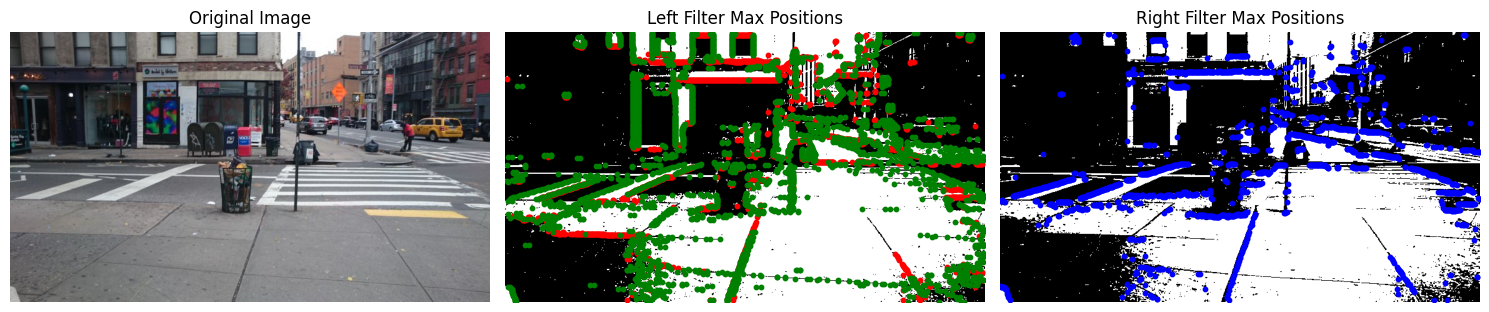

In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already run the code you provided

# Find the positions of the maximum values
max_left = np.max(result_left)
max_right = np.max(result_right)
max_up = np.max(result_up)
max_down = np.max(result_down)
positions_left = np.where(result_left == max_left)
positions_right = np.where(result_right == max_right)
positions_up = np.where(result_up == max_up)
positions_down = np.where(result_down == max_down)
# Create a visualization
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original image
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

# Left filter max positions
ax2.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))
ax2.scatter(positions_left[1], positions_left[0], color='red', s=10)
ax2.scatter(positions_up[1], positions_up[0], color='green', s=10)
ax2.scatter(positions_down[1], positions_down[0], color='green', s=10)
ax2.set_title('Left Filter Max Positions')
ax2.axis('off')

# Right filter max positions
ax3.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))
ax3.scatter(positions_right[1], positions_right[0], color='blue', s=10)
#ax3.scatter(positions_down[1], positions_down[0], color='red', s=10)
ax3.set_title('Right Filter Max Positions')
ax3.axis('off')

plt.tight_layout()
plt.show()


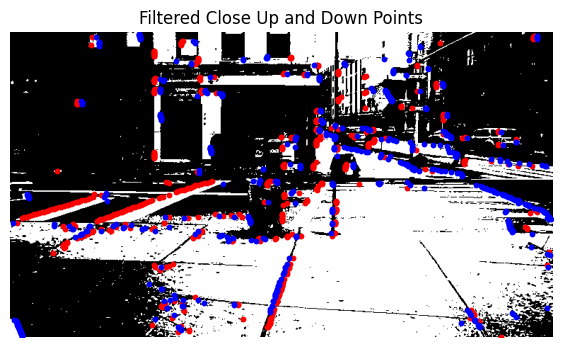

In [76]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def find_close_points(reference_points, target_points, threshold=5):
    close_points = []
    for y_t, x_t in zip(target_points[0], target_points[1]):
        for y_r, x_r in zip(reference_points[0], reference_points[1]):
            distance = np.sqrt((x_t - x_r) ** 2 + (y_t - y_r) ** 2)
            if distance < threshold:
                close_points.append((y_t, x_t))
                break
    return np.array(close_points).T if close_points else (np.array([], dtype=int), np.array([], dtype=int))

# Find close up and down points
close_up_left = find_close_points(positions_left, positions_up)
close_up_right = find_close_points(positions_right, positions_up)
close_down_left = find_close_points(positions_left, positions_down)
close_down_right = find_close_points(positions_right, positions_down)

# Concatenating results properly
close_up_points = (np.concatenate((close_up_left[0], close_up_right[0])), np.concatenate((close_up_left[1], close_up_right[1])))
close_down_points = (np.concatenate((close_down_left[0], close_down_right[0])), np.concatenate((close_down_left[1], close_down_right[1])))


close_up_points = ((close_up_right[0])), (close_up_right[1])
close_down_points = ((close_down_right[0]), (close_down_right[1]))

# Create a visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))

# Plot only the close up and down points in red
if close_up_points[0].size > 0:
    ax.scatter(close_up_points[1], close_up_points[0], color='red', s=10)
if close_down_points[0].size > 0:
    ax.scatter(close_down_points[1], close_down_points[0], color='blue', s=10)

ax.set_title('Filtered Close Up and Down Points')
ax.axis('off')

plt.show()


(array([  5,   6,   7,   8,   9,  12,  13,  14,  15,  16,  17,  18,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  37,  38,  39,  40,  41,
        44,  45,  65,  66,  67,  68,  69,  70,  72,  73,  74,  75,  76,
        77,  80,  81,  82,  83,  84,  85,  86,  92,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 116, 118, 119, 120, 125, 146, 148, 149,
       150, 151, 151, 152, 152, 153, 153, 154, 154, 155, 155, 156, 156,
       157, 157, 158, 158, 159, 159, 160, 160, 161, 162, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 181, 182, 183, 184, 184, 185, 186,
       187, 187, 188, 188, 188, 189, 189, 189, 190, 190, 190, 191, 191,
       191, 192, 192, 193, 194, 210, 211, 212, 213, 214, 215, 216, 217,
       229, 230, 231, 232, 233, 250, 251, 252, 253, 254, 257, 258, 259,
       260, 263, 264, 265, 266, 267, 271, 272, 273, 274, 275, 282, 283,
       284, 285, 286, 287, 288, 288, 289, 290, 297, 298, 300, 301, 302,
       304, 305, 354, 356, 357, 358, 359, 360, 361, 362, 363, 3

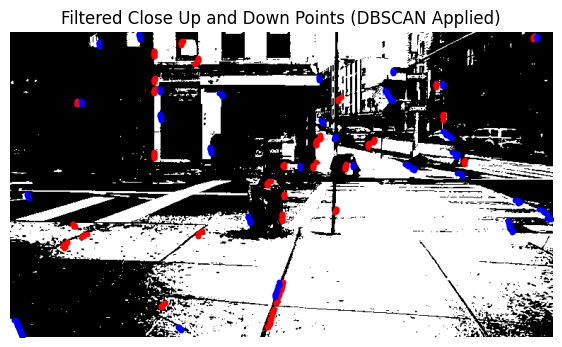

In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def find_close_points(reference_points, target_points, threshold=5):
    close_points = []
    for y_t, x_t in zip(target_points[0], target_points[1]):
        for y_r, x_r in zip(reference_points[0], reference_points[1]):
            distance = np.sqrt((x_t - x_r) ** 2 + (y_t - y_r) ** 2)
            if distance < threshold:
                close_points.append((y_t, x_t))
                break
    return np.array(close_points).T if close_points else (np.array([], dtype=int), np.array([], dtype=int))

def filter_by_dbscan(points, eps=5, min_samples=5):
    """Uses DBSCAN to filter out scattered points."""
    if points[0].size == 0:
        return points  # Return empty set if no points
    
    coords = np.column_stack((points[1], points[0]))  # Convert to (x, y) format
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
    
    # Get the labels (clusters)
    labels = clustering.labels_
    
    # Remove noise points (labeled as -1)
    filtered_coords = coords[labels != -1]
    
    if filtered_coords.size == 0:
        return (np.array([], dtype=int), np.array([], dtype=int))
    
    return (filtered_coords[:, 1], filtered_coords[:, 0])  # Return as (y, x)

# Find close up and down points
close_up_left = find_close_points(positions_left, positions_up)
close_up_right = find_close_points(positions_right, positions_up)
close_down_left = find_close_points(positions_left, positions_down)
close_down_right = find_close_points(positions_right, positions_down)

# Concatenate the results
close_up_points = (np.concatenate((close_up_left[0], close_up_right[0])), 
                   np.concatenate((close_up_left[1], close_up_right[1])))

close_down_points = (np.concatenate((close_down_left[0], close_down_right[0])), 
                     np.concatenate((close_down_left[1], close_down_right[1])))


close_up_points = ((close_up_right[0])), (close_up_right[1])
close_down_points = ((close_down_right[0]), (close_down_right[1]))

# Apply DBSCAN to remove scattered points
filtered_up_points = filter_by_dbscan(close_up_points, eps=5, min_samples=5)
filtered_down_points = filter_by_dbscan(close_down_points, eps=5, min_samples=5)

# Create a visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))

print(filtered_up_points)
print(filtered_down_points)
# Plot only the filtered up and down points
if filtered_up_points[0].size > 0:
    ax.scatter(filtered_up_points[1], filtered_up_points[0], color='red', s=10)
if filtered_down_points[0].size > 0:
    ax.scatter(filtered_down_points[1], filtered_down_points[0], color='blue', s=10)

ax.set_title('Filtered Close Up and Down Points (DBSCAN Applied)')
ax.axis('off')

plt.show()


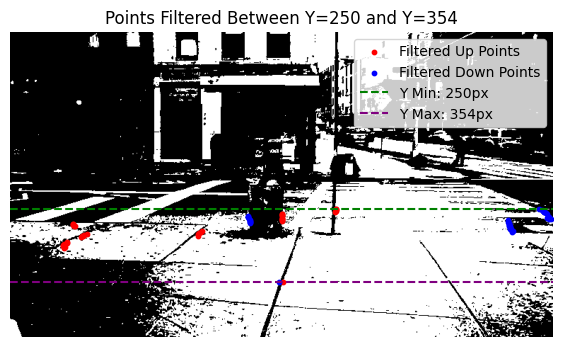

In [80]:
def filter_points_between_y_range(filtered_up_points, filtered_down_points, cnn_y_coords, img_height=576):
    """Filters up and down points to only keep those between the CNN's Y range."""
    
    # Denormalize the CNN Y coordinates
    y_min, y_max = [int(y * img_height) for y in cnn_y_coords]  # Convert to pixel values

    # Filter up and down points based on Y range
    mask_up = (filtered_up_points[0] >= y_min) & (filtered_up_points[0] <= y_max)
    mask_down = (filtered_down_points[0] >= y_min) & (filtered_down_points[0] <= y_max)

    filtered_up = (filtered_up_points[0][mask_up], filtered_up_points[1][mask_up])
    filtered_down = (filtered_down_points[0][mask_down], filtered_down_points[1][mask_down])

    return filtered_up, filtered_down, y_min, y_max

# Example usage
cnn_y_coords = [0.4351651072502136, 0.6160516738891602]  # Example normalized Y output from CNN
filtered_up_points, filtered_down_points, y_min, y_max = filter_points_between_y_range(
    filtered_up_points, filtered_down_points, cnn_y_coords
)

# Visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))

# Plot filtered points
if filtered_up_points[0].size > 0:
    ax.scatter(filtered_up_points[1], filtered_up_points[0], color='red', s=10, label="Filtered Up Points")
if filtered_down_points[0].size > 0:
    ax.scatter(filtered_down_points[1], filtered_down_points[0], color='blue', s=10, label="Filtered Down Points")

# Draw the CNN Y boundaries
ax.axhline(y_min, color='green', linestyle='--', label=f'Y Min: {y_min}px')
ax.axhline(y_max, color='purple', linestyle='--', label=f'Y Max: {y_max}px')

ax.set_title(f'Points Filtered Between Y={y_min} and Y={y_max}')
ax.axis('off')
plt.legend()
plt.show()


In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_hough_transform(points, img_shape=(768, 576), threshold=15):
    """Applies Hough Transform to find the best line passing through the most points."""
    
    # Create an empty binary image
    edge_image = np.zeros(img_shape, dtype=np.uint8)

    # Plot points onto binary image
    for y, x in zip(points[0], points[1]):
        edge_image[int(y), int(x)] = 255

    # Apply Gaussian blur to smooth edges and improve detection
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 0)

    # Apply Hough Line Transform
    lines = cv2.HoughLines(edge_image, rho=1, theta=np.pi/180, threshold=threshold)

    return lines

# Apply Hough Transform separately for up & down points
lines_up = apply_hough_transform(filtered_up_points, threshold=20)  # Adjust threshold for better detection
lines_down = apply_hough_transform(filtered_down_points, threshold=15)  # Lower threshold if needed

# Visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))

# Scatter filtered points
ax.scatter(filtered_up_points[1], filtered_up_points[0], color='red', s=10, label="Filtered Up Points")
ax.scatter(filtered_down_points[1], filtered_down_points[0], color='blue', s=10, label="Filtered Down Points")

# Draw detected Hough line for Up Points (Red Line)
if lines_up is not None:
    rho, theta = lines_up[0][0]  # Take the strongest detected line
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
    ax.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Hough Line (Up)")

# Draw detected Hough line for Down Points (Blue Line)
if lines_down is not None:
    rho, theta = lines_down[0][0]  # Take the strongest detected line
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
    ax.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label="Hough Line (Down)")

ax.set_title('Hough Transform: Two Separate Lines')
ax.axis('off')
ax.legend()
plt.show()


IndexError: index 749 is out of bounds for axis 1 with size 576

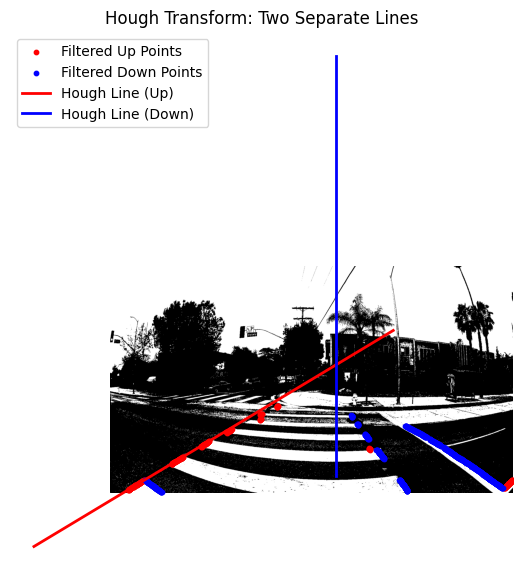

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_hough_transform(points, img_shape=(1920, 1080), threshold=15):
    """Applies Hough Transform to find the best line passing through the most points."""
    
    # Create an empty binary image
    edge_image = np.zeros(img_shape, dtype=np.uint8)
    height, width = img_shape  # Unpack dimensions

    # Plot points onto binary image (Ensure points stay within bounds)
    for y, x in zip(points[0], points[1]):
        y = max(0, min(height - 1, int(y)))  # Clamp Y within [0, height-1]
        x = max(0, min(width - 1, int(x)))   # Clamp X within [0, width-1]
        edge_image[y, x] = 255

    # Apply Gaussian blur to smooth edges and improve detection
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 0)

    # Apply Hough Line Transform
    lines = cv2.HoughLines(edge_image, rho=1, theta=np.pi/180, threshold=threshold)

    return lines

# Apply Hough Transform separately for up & down points
lines_up = apply_hough_transform(filtered_up_points, img_shape=(1920, 1080), threshold=20)
lines_down = apply_hough_transform(filtered_down_points, img_shape=(1920, 1080), threshold=15)

# Visualization
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(cv2.cvtColor(binary, cv2.COLOR_BGR2RGB))

# Scatter filtered points
ax.scatter(filtered_up_points[1], filtered_up_points[0], color='red', s=10, label="Filtered Up Points")
ax.scatter(filtered_down_points[1], filtered_down_points[0], color='blue', s=10, label="Filtered Down Points")

# Draw detected Hough line for Up Points (Red Line)
if lines_up is not None:
    rho, theta = lines_up[0][0]  # Take the strongest detected line
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
    ax.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label="Hough Line (Up)")

# Draw detected Hough line for Down Points (Blue Line)
if lines_down is not None:
    rho, theta = lines_down[0][0]  # Take the strongest detected line
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
    ax.plot([x1, x2], [y1, y2], 'b-', linewidth=2, label="Hough Line (Down)")

ax.set_title('Hough Transform: Two Separate Lines')
ax.axis('off')
ax.legend()
plt.show()
